In [156]:
import copy
import torch
import tqdm
import numpy as np 
import gymnasium as gym
from typing import List, Literal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

In [178]:
N = 100 # number of datapoints 
x = np.linspace(-2, 2, N) # sequences from -3 to 3 with N values

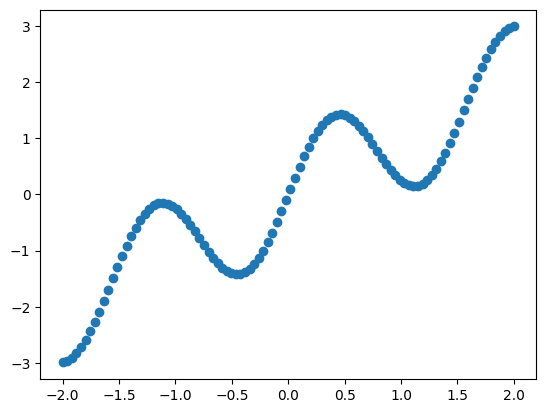

In [179]:
sine_wave = x + np.sin(4*x)
plt.plot(x, sine_wave, 'o');

In [180]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

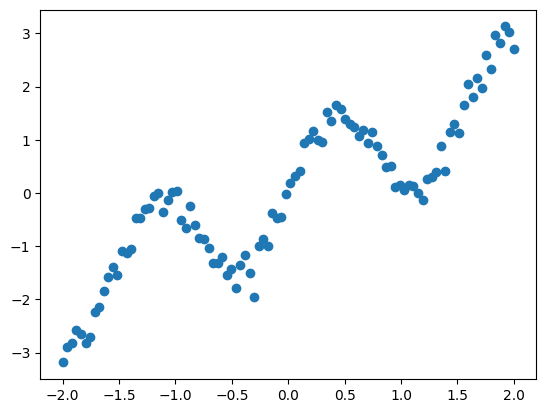

In [202]:
noisy_sine_wave = x + np.sin(4*x) + np.random.normal(0,0.2, 100)
plt.plot(x, noisy_sine_wave, 'o')

In [216]:
# neural network regression
# this has the same architecture for every hidden layer by design
model = torch.nn.Sequential(
    torch.nn.Linear(1, 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24), # hidden layer 1
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24), # hidden layer 2
    torch.nn.ReLU(),
    torch.nn.Linear(24, 1)
)
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

#### MSE or Mean Square Error
$(1/N)*(\sum_{i}^{N} (y_i - y_{hat})^2)$, where N is the # of data points

In [210]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(X_train, y_train, X_test, y_test, n_epochs=100, batch_size=1):
    batch_start = torch.arange(0, len(X_train), batch_size)
    best_mse = np.inf
    best_weights = None
    history = []
    
    for epoch in range(n_epochs):
        # train batches
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # update weights via backprop
                opt.zero_grad()
                loss.backward()
                opt.step()

                # print
                bar.set_postfix(mse=float(loss))

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
    
    return history, best_mse, best_weights


In [211]:
x_for_split = x.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [212]:
history, best_mse, best_weights = train_regression_model(X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test,
                                                         n_epochs=1000, 
                                                         batch_size=1)

MSE: 0.01
RMSE: 0.09


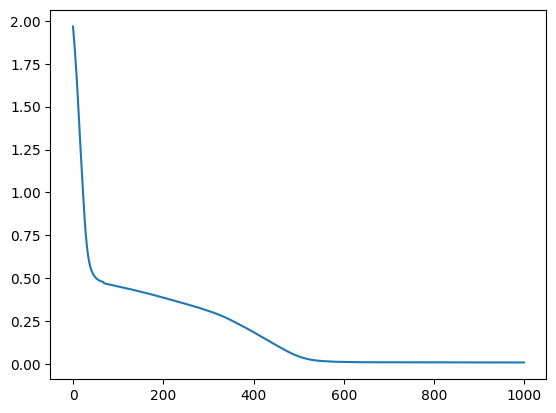

In [213]:
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [214]:
nhistory, nbest_mse, nbest_weights = train_regression_model(noisy_X_train, 
                                                         noisy_y_train, 
                                                         noisy_X_test, 
                                                         noisy_y_test,
                                                         n_epochs=1000, 
                                                         batch_size=1)

MSE: 0.05
RMSE: 0.23


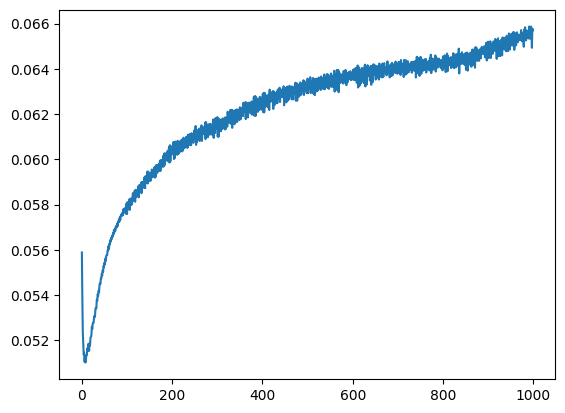

In [215]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.plot(nhistory)
plt.show()

In [143]:
class Env(gym.Env):
    '''
    Contains the states and the rewards for those states.

    state is the output of the linear layers 

    step() returns the next layer as well as the reward
        - to return the reward need the loss
    '''
    def __init__(self, 
                 mode: Literal['train', 'generalize']='train', 
                 num_layers: int=100, 
                 num_nodes_per_layer:int=64,
                 seed:int=4):
        np.random.seed(seed)
        self.state = self.init_state(mode)
        self.num_layers = num_layers
        self.num_nodes_per_layer = num_nodes_per_layer

        # initialize layers with xavier uniform or normal
        self.layers = self.init_layers(num_layers=num_layers, num_nodes_per_layer=num_nodes_per_layer)
        self.observation_space = gym.spaces.Box(low=float('inf'), high=float('-inf'), shape=(num_nodes_per_layer,))

        # action is vector of probabilities corresponding to which layer
        # this is output by the agent
        self.action_space = gym.spaces.Box(low=0., high=1., shape=(num_layers+1,)) # +1 for the 'no layer' option

    def init_state(self, mode: Literal['train', 'generalize']='train'):
        if mode=='train':
            # return random layer
            return self.layers[np.random.choice(self.num_layers, 1)]
        elif mode=='generalize':
            # return favorable layer
            # TODO(ms): what makes a layer favorable? should this be random for now?
            pass
        else:
            raise ValueError("Wrong mode passed.")

    
    def init_layers(self, num_layers=100, num_nodes_per_layer=128) -> List[np.ndarray]:
        self.layers = [torch.nn.Linear(num_nodes_per_layer) for _ in num_layers]
        self.layers = [torch.nn.init.xavier_uniform(layer.weight) for layer in self.layers]

    def reset(self):
        self.layers = self.init_layers(num_layers=self.num_layers, num_nodes_per_layer=self.num_nodes_per_layer)
    
    def step(self, ):
        state_prime = state
        return state_prime, reward, done, truncated, {}

In [ ]:
class Agent:
    '''A2C serving the next layer
    '''
    def __init__(self, mode='train'):
        
